In [2]:
### Imports

import pandas as pd
import numpy as np
import xarray as xr

import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from src.helpers import *
from sklearn.metrics import *

import pickle
import math

import sys
sys.path.append("c:\\Users\\nerea\\OneDrive\\Documentos\\EPFL_MASTER\\PDM\\Project\\PyalData")
# to change for the actual path where PyalData has been cloned

from pyaldata import *

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_dir = "./Data"

fname = os.path.join(data_dir, "Chewie_CO_FF_2016-10-07.mat")

name = 'Chewie'
date = '1007'
path_to_save_data = os.path.join(data_dir, 'Processed_Data', 'Tidy_'+name+'_'+str(date)+'.pkl')


In [6]:
# Load TrialData .mat file into a DataFrame
df = mat2dataframe_NC(fname, shift_idx_fields=True, td_name = 'trial_data') 

In [7]:
# Combine time-bins into longer ones
td = combine_time_bins(df, 2)

In [8]:
# Remove low-firing neurons
td = remove_low_firing_neurons(td, "M1_spikes",  5)
td = remove_low_firing_neurons(td, "PMd_spikes", 5)

/home/nerea/CL_UpperLimb_Control/./PyalData/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/nerea/CL_UpperLimb_Control/./PyalData/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


In [9]:
# Transform signals
td = transform_signal(td, "M1_spikes",  'sqrt')
td = transform_signal(td, "PMd_spikes", 'sqrt')

In [10]:
# Merge signals
# Signals from the pre-motor and motor cortex are now combines in one same variable, 
# we do not consider the 2 regions as different but more as functionally working together.
td = merge_signals(td, ["M1_spikes", "PMd_spikes"], "both_spikes")
# Compute firing rates
td = add_firing_rates(td, 'smooth')


In [14]:
td.columns

Index(['monkey', 'date', 'task', 'target_direction', 'trial_id', 'result',
       'bin_size', 'perturbation', 'perturbation_info', 'epoch',
       'idx_trial_start', 'idx_target_on', 'idx_go_cue', 'idx_movement_on',
       'idx_peak_speed', 'idx_trial_end', 'pos', 'vel', 'acc', 'force',
       'M1_spikes', 'M1_unit_guide', 'PMd_spikes', 'PMd_unit_guide',
       'both_spikes', 'M1_rates', 'PMd_rates', 'both_rates'],
      dtype='object')

In [87]:
td_filt = td.loc[td.result == 'R'].reset_index()

In [88]:
td_filt.trial_id.nunique()

330

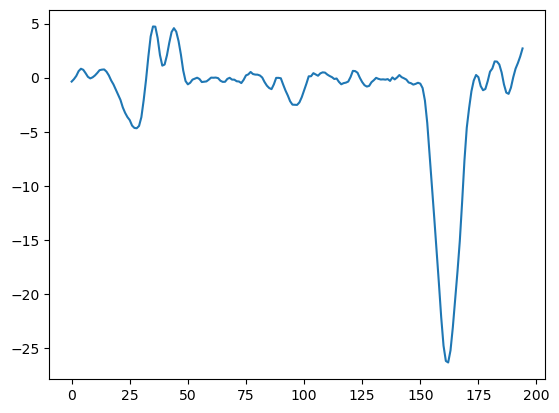

In [111]:
plt.plot(td_filt.vel[50][:,0])

# For now it looks like  the trials have very different shapes, I should decide a fixed shape for the project, first check if some trials have more than one reach inside.

In [90]:
len(td.vel[3])

189

In [91]:
td.M1_spikes[3].shape

(189, 47)

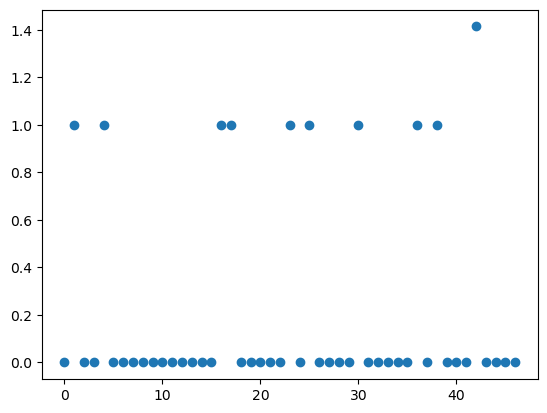

In [94]:
plt.scatter(np.arange(0,47),td.M1_spikes[3][0,:])

In [95]:
trial_lengths = [td.vel[i].shape[0] for i in range(len(td.vel))]

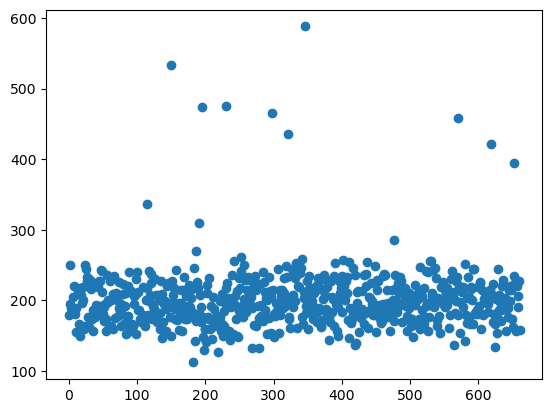

In [96]:
plt.scatter(np.arange(0, len(trial_lengths)), trial_lengths)

In [97]:
min_l = np.min(trial_lengths)
max_l = np.max(trial_lengths)
print(min_l, max_l)

112 588


In [98]:
np.argmax(trial_lengths)

346

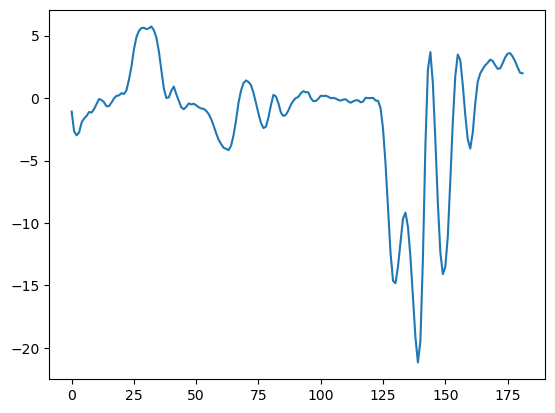

In [106]:
plt.plot(td.vel[347][:,0])

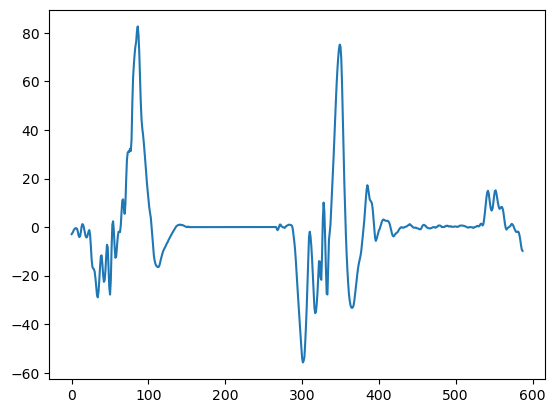

In [107]:
plt.plot(td.vel[346][:, 0])

In [103]:
td.M1_rates[0].shape

(179, 47)

In [49]:
a = td.explode(['pos', 'vel', 'M1_rates', 'PMd_rates', 'both_rates']).reset_index()

In [50]:
a.loc[a.trial_id == 1]

,index,monkey,date,task,target_direction,trial_id,result,bin_size,perturbation,perturbation_info,...,acc,force,M1_spikes,M1_unit_guide,PMd_spikes,PMd_unit_guide,both_spikes,M1_rates,PMd_rates,both_rates
0,0,Chewie,10-07-2016,CO,0.785398,1,R,0.02,FF,"[0.15, -1.48]",...,"[[-34.20058356024036, 65.61549950450491], [-42...","[[0.16237358040946678, 0.3526423959951813], [0...","[[1.4142135623730951, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1], [3, 1], [4, 1], [5, 1], [9, 1], [10, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1], [7, 2], [7, 3], [29, 2], [30, 1], [30...","[[1.4142135623730951, 0.0, 0.0, 0.0, 0.0, 0.0,...","[38.4272, 11.205347, 13.455679, 26.138788, 0.0...","[9.883548, 3.2982376, 6.3081317, 13.365311, 3....","[38.4272, 11.205347, 13.455679, 26.138788, 0.0..."
1,0,Chewie,10-07-2016,CO,0.785398,1,R,0.02,FF,"[0.15, -1.48]",...,"[[-34.20058356024036, 65.61549950450491], [-42...","[[0.16237358040946678, 0.3526423959951813], [0...","[[1.4142135623730951, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1], [3, 1], [4, 1], [5, 1], [9, 1], [10, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1], [7, 2], [7, 3], [29, 2], [30, 1], [30...","[[1.4142135623730951, 0.0, 0.0, 0.0, 0.0, 0.0,...","[35.440273, 11.961129, 16.429155, 25.793085, 0...","[10.043954, 4.331614, 7.3337827, 12.3232, 4.50...","[35.440273, 11.961129, 16.429155, 25.793085, 0..."
2,0,Chewie,10-07-2016,CO,0.785398,1,R,0.02,FF,"[0.15, -1.48]",...,"[[-34.20058356024036, 65.61549950450491], [-42...","[[0.16237358040946678, 0.3526423959951813], [0...","[[1.4142135623730951, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1], [3, 1], [4, 1], [5, 1], [9, 1], [10, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1], [7, 2], [7, 3], [29, 2], [30, 1], [30...","[[1.4142135623730951, 0.0, 0.0, 0.0, 0.0, 0.0,...","[30.812984, 12.99325, 20.933218, 24.655056, 0....","[10.141166, 5.952143, 8.895794, 10.668998, 6.4...","[30.812984, 12.99325, 20.933218, 24.655056, 0...."
3,0,Chewie,10-07-2016,CO,0.785398,1,R,0.02,FF,"[0.15, -1.48]",...,"[[-34.20058356024036, 65.61549950450491], [-42...","[[0.16237358040946678, 0.3526423959951813], [0...","[[1.4142135623730951, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1], [3, 1], [4, 1], [5, 1], [9, 1], [10, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1], [7, 2], [7, 3], [29, 2], [30, 1], [30...","[[1.4142135623730951, 0.0, 0.0, 0.0, 0.0, 0.0,...","[26.42189, 13.634284, 24.72684, 22.308786, 1.1...","[10.032214, 7.4131675, 10.356075, 9.104809, 8....","[26.42189, 13.634284, 24.72684, 22.308786, 1.1..."
4,0,Chewie,10-07-2016,CO,0.785398,1,R,0.02,FF,"[0.15, -1.48]",...,"[[-34.20058356024036, 65.61549950450491], [-42...","[[0.16237358040946678, 0.3526423959951813], [0...","[[1.4142135623730951, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1], [3, 1], [4, 1], [5, 1], [9, 1], [10, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 1], [7, 2], [7, 3], [29, 2], [30, 1], [30...","[[1.4142135623730951, 0.0, 0.0, 0.0, 0.0, 0.0,...","[23.698915, 13.380146, 25.842861, 18.893782, 2...","[9.835945, 7.991666, 11.296891, 8.263098, 10.6...","[23.698915, 13.380146, 25.842861, 18.893782, 2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84789,422,Chewie,10-07-2016,CO,1.570796,1,F,0.02,FF,"[0.15, -1.48]",...,"[[44.09329458427308, 66.21875740744937], [21.4...","[[0.005357012713075052, 0.30677783497294897], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...","[[1, 1], [3, 1], [4, 1], [5, 1], [9, 1], [10, ...","[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0,...","[[1, 1], [7, 2], [7, 3], [29, 2], [30, 1], [30...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...","[4.502161, 23.618074, 0.0, 0.0, 15.80714, 18.9...","[0.0, 0.20599091, 0.0, 0.0, 0.0005780757, 26.9...","[4.502161, 23.618074, 0.0, 0.0, 15.80714, 18.9..."
84790,422,Chewie,10-07-2016,CO,1.570796,1,F,0.02,FF,"[0.15, -1.48]",...,"[[44.09329458427308, 66.21875740744937], [21.4...","[[0.005357012713075052, 0.30677783497294897], ...","[[0.0, 0.0